## Segmentacion Renal

In [1]:
import numpy as np
import nrrd
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings("ignore")

In [100]:
## ventaneo
def show_slice_window(slice, level, window):
    """
   Function to display an image slice
   Input is a numpy 2D array
   """

    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    #plt.figure()
    #plt.imshow(slice, cmap="gray", origin="lower")
    #plt.savefig('L'+str(level)+'W'+str(window))
    return(slice)


def rotateMask(mask):
    maskRot = cv2.rotate(mask, cv2.cv2.ROTATE_90_CLOCKWISE)
    maskRot = cv2.flip(maskRot,1)
    return(maskRot)
    
def resampling(imagenes,mascaras,n_slices):
    
    volumen_img  = []
    volumen_mask = []
    
    coronales_img = []
    coronales_mask = []
    axial_img_resampled = []
    axial_mask_resampled = []
        

    dim = imagenes[0].shape[1],n_slices

    for i in range(imagenes.shape[1]):
        img_temp = imagenes[:,i,:]
        mask_temp = mascaras[:,i,:]
        img_resize = cv2.resize(img_temp, dim,interpolation = cv2.INTER_CUBIC)
        mask_resize = cv2.resize(mask_temp, dim,interpolation = cv2.INTER_CUBIC)
        coronales_img.append(img_resize.astype('float32'))
        coronales_mask.append(mask_resize.astype('float32'))
    coronales_img = np.array(coronales_img)
    coronales_mask = np.array(coronales_mask)   
      
    #     print('img:', img_paciente.shape)
    #     print('mask:', mask_paciente.shape)


    for k in range(coronales_img.shape[1]):
        axial_temp = coronales_img[:,k,:]
        mask_temp = coronales_mask[:,k,:]
        axial_img_resampled.append(axial_temp)
        axial_mask_resampled.append(mask_temp)

    axial_img_resampled = np.array(axial_img_resampled)
    axial_mask_resampled = np.array(axial_mask_resampled)
    #axial_mask_resampled = np.where(axial_mask_resampled > 0.5, 1,0)
    

    
    return(axial_img_resampled, axial_mask_resampled)
    

In [119]:
### Se carga un ejemplo de TC con cáncer de pulmón y su segmentaión realizada por radiólogo

data_img, header_img = nrrd.read('./segmentacion renal/case_00046_arterial_image.nrrd', index_order = 'F')
data_mask, header_mask = nrrd.read('./segmentacion renal/case_00046_arterial_segmentation.nrrd', index_order = 'F')

print(data_img.shape)
print(data_mask.shape)

(159, 512, 512)
(159, 512, 512)


In [120]:
imgResampled, maskResampled = resampling(data_img, data_mask, 512)

In [121]:
imgResampled.shape

(512, 512, 512)

In [122]:
maskResampled.shape

(512, 512, 512)

In [123]:
## Tamaño Voxel
header_img['space directions']

array([[-0.       ,  0.       , -3.       ],
       [ 0.       ,  0.9765625,  0.       ],
       [ 0.9765625,  0.       ,  0.       ]])

In [124]:
maskResampled.max()

2.0

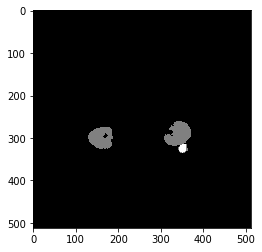

In [125]:
plt.figure()
plt.imshow(maskResampled[180,:,:], cmap='gray')

In [126]:
import math

imagenes = []
mascaras = []
positive_slices = []

for a in range(maskResampled.shape[0]):
    segmentation = maskResampled[a,:,:]
    if (np.sum(segmentation)>0):
        positive_slices.append(a)
        
print(len(positive_slices))
## En caso de querer incluir mas segmentos por sobre y bajo la imagen segmentada:
## numero_slices = 150
#dif = numero_slices - len(positive_slices)
#low_limit = math.floor(dif/2)
#high_limit = math.ceil(dif/2)

#new_positive_slices = list(range((positive_slices[0] - low_limit), (positive_slices[-1] + high_limit + 1)))

for axial in range(len(positive_slices)):
    segment = maskResampled[positive_slices[axial],:,:]
    ct = imgResampled[positive_slices[axial],:,:]
    segment = maskResampled[positive_slices[axial],:,:]
    ct = imgResampled[positive_slices[axial],:,:]
    imagenes.append(ct)
    mascaras.append(segment)
    
imagenes = np.array(imagenes)
mascaras = np.array(mascaras)

print(imagenes.shape)
print(mascaras.shape)

161
(161, 512, 512)
(161, 512, 512)


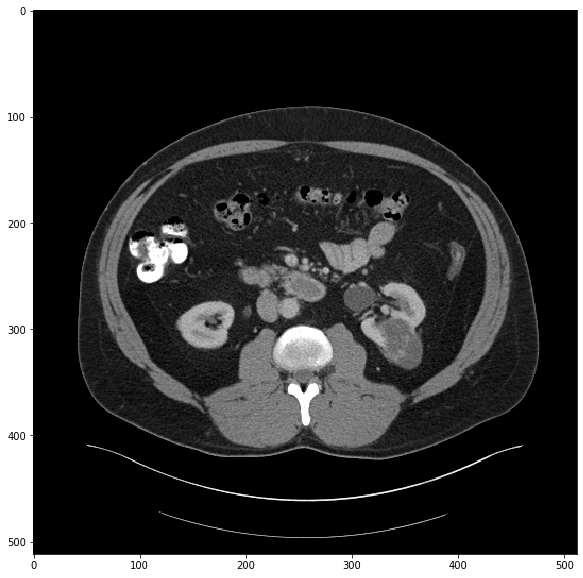

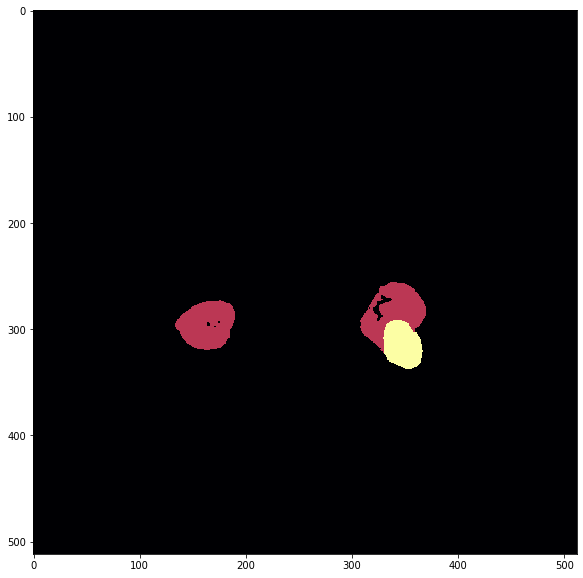

In [343]:
imageExtract = imagenes[105,:,:]
maskExtract = mascaras[105,:,:]

image = show_slice_window(imageExtract, 50,400)
#image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
#image= cv2.flip(image,1)

#mask = cv2.rotate(maskExtract, cv2.cv2.ROTATE_90_CLOCKWISE)
#mask = cv2.flip(mask,1)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.savefig('renalImage.png', dpi=600)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(maskExtract, cmap='inferno')
plt.savefig('renalMask.png', dpi=300)
plt.show()

In [336]:
maskExtract.max()

2.0

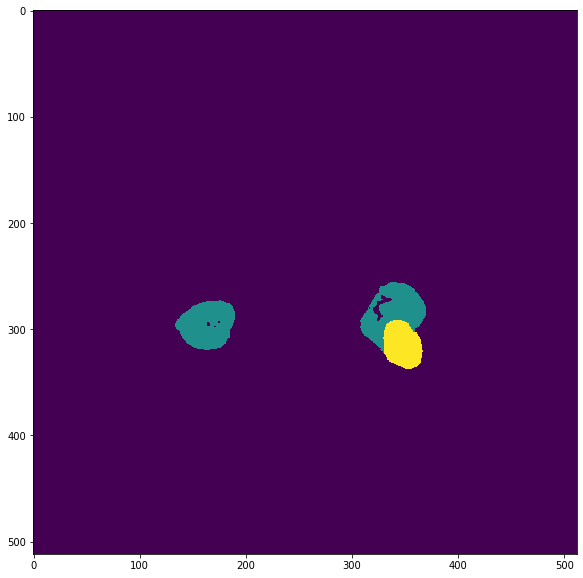

In [178]:

plt.figure(figsize=(10,10))
plt.imshow(maskExtract, cmap='viridis')
plt.savefig('renalMask2.png', dpi=300)
plt.show()

In [338]:
recall_score(maskExtract.flatten(), maskExtract.flatten(), average='weighted')

1.0

1.0
(512, 512)
1320.0


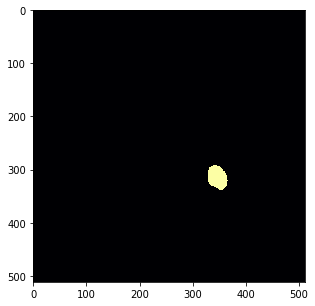

In [327]:
## segunda máscara renal con mayor cobertura

maskLarge = np.where(maskExtract == 1, 0, maskExtract)
maskLarge = np.where(maskExtract == 2, 1, 0)
maskLarge = maskLarge.astype('float32')


print(maskLarge.max())
print(maskLarge.shape)
print(maskLarge.sum())

plt.figure(figsize=(5,5))
plt.imshow(maskLarge, cmap='inferno')
plt.savefig('tumorrenal.png', dpi=300)
plt.show()


In [319]:
maskLarge.max()

1

In [325]:
maskBig = cv2.imread('tumorrenalBig.png',0)

maskBig = cv2.resize(maskBig, (512, 512),
               interpolation = cv2.INTER_NEAREST)

maskBig = maskBig/255
print(maskBig.max())
maskBig.shape

1.0


(512, 512)

In [339]:
maskBig = np.where(maskBig !=0, 1, 0)

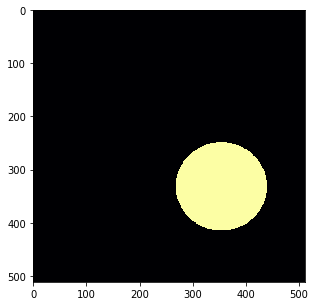

In [350]:

plt.figure(figsize=(5,5))
plt.imshow(maskBig, cmap='inferno')
#plt.savefig('mascaraBigInferno.png', dpi=600)
plt.show()

In [341]:
from sklearn.metrics import recall_score

recall_score(maskLarge.flatten(), maskBig.flatten())

1.0

In [171]:
imgResampled, maskResampled = resampling(imagenes, mascaras, 128)

In [172]:
## redimensionado de máscaras

imgResize = []
maskResize = []
dim = 128,128

for i in range(imgResampled.shape[0]):
    img = imgResampled[i,:,:]
    imgRes = cv2.resize(img,dim, interpolation = cv2.INTER_CUBIC )
    mask = maskResampled[i,:,:]
    maskRes = cv2.resize(mask,dim, interpolation = cv2.INTER_CUBIC )
    imgResize.append(imgRes)
    maskResize.append(maskRes)
    
imgResize = np.array(imgResize)
maskResize = np.array(maskResize)

In [173]:
maskResize.shape

(128, 128, 128)

In [174]:
volumenRotado = np.zeros(maskResize.shape, dtype='uint8')

for i in range(maskResize.shape[0]):
    mask = maskResize[i,:,:]
    maskRot = rotateMask(mask)
    volumenRotado[i,:,:] = maskRot

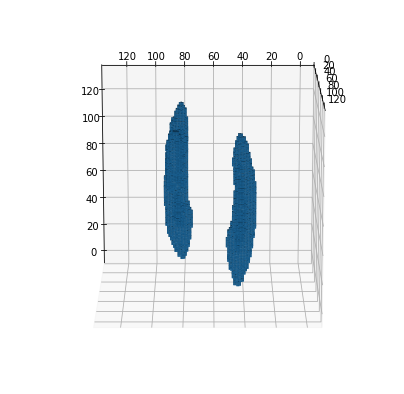

tiempo iteración: 54.4122531414032


In [175]:
from mpl_toolkits import mplot3d
import time

start = time.time()

ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.voxels(volumenRotado, edgecolor=None, cmap='plasma')

#angulo_elevacion = 210
#angulo_rotacion = 110

angulo_elevacion = 105
angulo_rotacion = 180

ax.view_init(angulo_elevacion, angulo_rotacion)
#plt.savefig('Renal3D.png', dpi=600)
plt.show()


print("tiempo iteración:", time.time()-start)

In [236]:
### Segundo Caso Segmentación Lesión hepàtica


liver_img, header_img = nrrd.read('liverMRI.nrrd', index_order = 'F')
liver_mask, header_mask = nrrd.read('liverMRISeg.nrrd', index_order = 'F')

print(liver_img.shape)
print(liver_mask.shape)


(320, 260, 80)
(320, 260, 80)


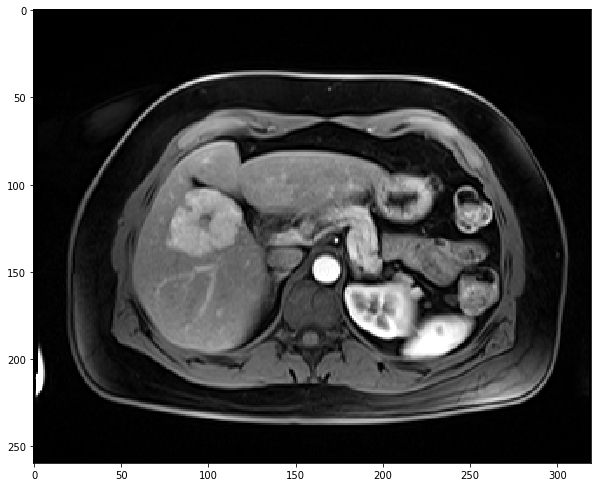

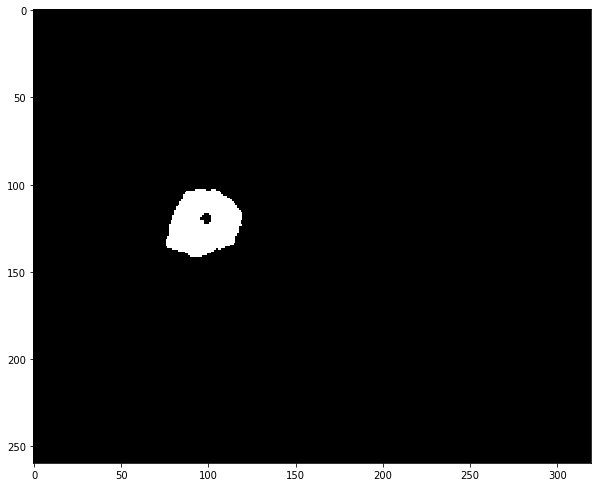

In [260]:

corte = 41


image = show_slice_window(liver_img[:,:,corte], 50,400)
image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
image= cv2.flip(image,1)

mask = liver_mask[:,:,corte]
mask = cv2.rotate(mask, cv2.cv2.ROTATE_90_CLOCKWISE)
mask= cv2.flip(mask,1)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.savefig('liverImage.png', dpi=600)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(mask, cmap='gray')
plt.savefig('LiverMask.png', dpi=600)
plt.show()



In [267]:
liverSingle = cv2.imread('liverimageFORMAT.png', 0)
maskResize = cv2.resize(mask, (liverSingle.shape[1],liverSingle.shape[0]),
               interpolation = cv2.INTER_NEAREST)

print(liverSingle.shape)
print(maskResize.shape)

(934, 1310)
(934, 1310)


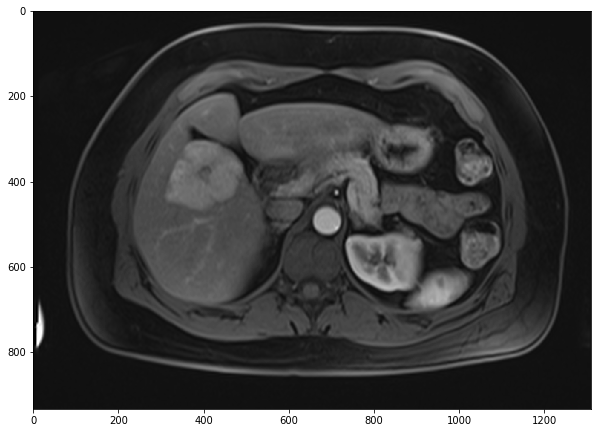

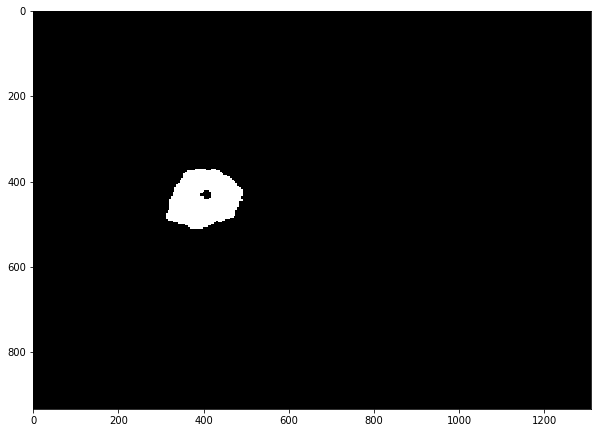

In [269]:
plt.figure(figsize=(10,10))
plt.imshow(liverSingle, cmap='gray')
plt.savefig('liverImage.png', dpi=600)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(maskResize, cmap='gray')
plt.savefig('LiverMask.png', dpi=600)
plt.show()

In [270]:
fullMask = np.zeros(maskResize.shape)

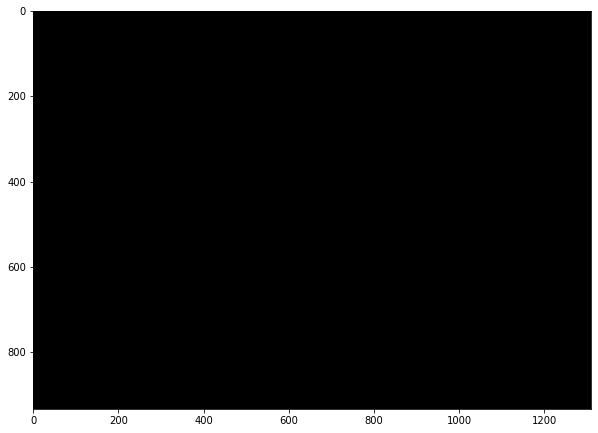

In [274]:

plt.figure(figsize=(10,10))
plt.imshow(fullMask, cmap='gray')
plt.savefig('fullMaskLiver.png', dpi=600)
plt.show()

In [264]:
liverSingle.shape

(934, 1310)

In [275]:
mask.sum() / (mask.shape[0] * mask.shape[1])

0.014879807692307692

In [277]:
(mask.shape[0] * mask.shape[1])

83200

In [276]:
mask.sum() 

1238

$ accuracy = \frac{VP + VN}{VP + VN + FN + FP}$

$ especificidad = \frac{VN}{VN + FP}$

$ precision = \frac{VP}{VP + FP}$

$ recall (sensibilidad) = \frac{VP}{VP + FN}$

$ Jaccard = \frac{VP}{VP + FN + FP}$

$ Dice = \frac{2VP}{2VP + FN + FP}$

$ lesión = 1238 pixeles^2$

$ 0.9852 = \frac{0 + 83200}{0 + 83200 + 1238 + 0}$

$ 1 = \frac{83200}{83200+ 0}$


In [279]:
### especificidad

83200/(83200 + 0)

1.0

## Segmentacion Pulmonar


In [181]:
import os

PATH = './segmentacion pulmonar'

os.listdir(PATH)

['Copia de lungSegmentation.nrrd',
 '.DS_Store',
 'Gonzalez_Arrigorriaga_Pedro',
 '8.png',
 'lungSegmentation.nrrd',
 'Captura de Pantalla 2022-08-26 a la(s) 11.04.48.png',
 'mask_3.png',
 'Captura de Pantalla 2022-08-26 a la(s) 11.05.02.png',
 'Captura de Pantalla 2022-08-26 a la(s) 11.05.11.png',
 'mask_8.png',
 'MATRIZ CONFUSION SEGMENTACION.png',
 '3.png',
 'lungImage.nrrd']

In [185]:
rx = cv2.imread('./segmentacion pulmonar/3.png', 0)
lungMask = cv2.imread('./segmentacion pulmonar/mask_3.png', 0)
lungMask = cv2.resize(lungMask, (512,512),  interpolation = cv2.INTER_NEAREST)

print(rx.shape)
print(lungMask.shape)

(512, 512)
(512, 512)


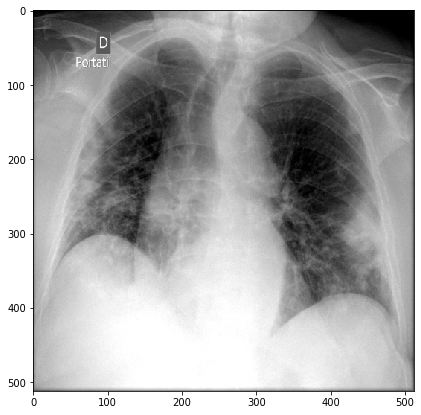

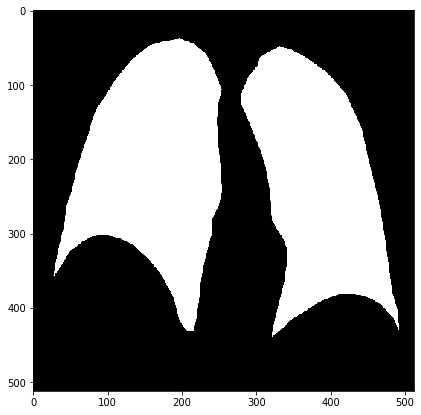

In [188]:
plt.figure(figsize=(7,7))
plt.imshow(rx, cmap='gray')
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(lungMask, cmap='gray')
plt.show()

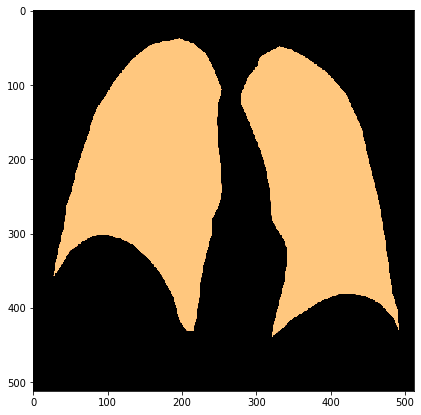

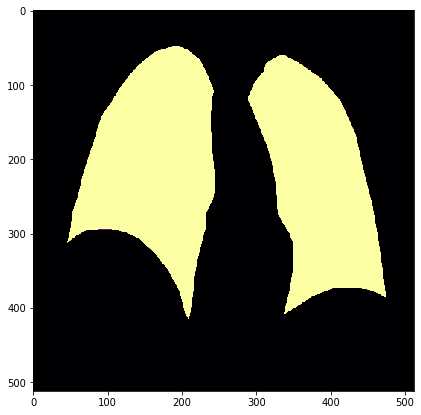

In [232]:
kernel = np.ones((17,17))

lungMaskErode = cv2.erode(lungMask, kernel)

plt.figure(figsize=(7,7))
plt.imshow(lungMask, cmap='copper')
plt.savefig('lungMaskGroundTruth.png', dpi=600)
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(lungMaskErode, cmap='inferno')
plt.savefig('lungMaskPrediction.png', dpi=600)

plt.show()

In [217]:
from sklearn.metrics import accuracy_score

accuracy_score(lungMask.flatten(), lungMaskErode.flatten())

0.9216041564941406

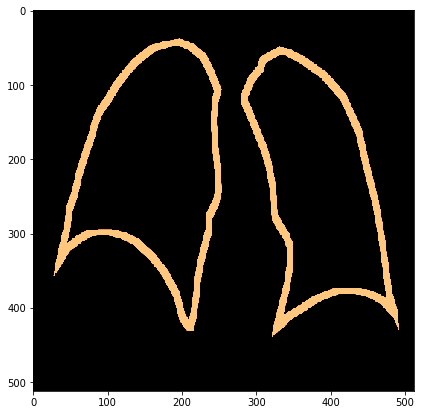

In [233]:
## Diferencias entre máscaras
lungDif = lungMask - lungMaskErode


plt.figure(figsize=(7,7))
plt.imshow(lungDif, cmap='copper')
plt.savefig('lungMaskDif.png', dpi=600)

plt.show()

In [21]:
## redimensionado
#dim = 60,60

#imgRes = cv2.resize(segDos, dim,
#               interpolation = cv2.INTER_NEAREST)

#print(imgRes.shape)
 
#plt.figure(figsize=(10,10))
#plt.imshow(imgRes, cmap='gray')
#plt.savefig('masklowRes.png', dpi=300)

In [22]:
#import dataframe_image as dfi


#df = pd.DataFrame(imgResBin)

#df_styled = df.style.background_gradient()

#dfi.export (df_styled, 'df_ct.png')
#dfi.export (df, 'df_ct_original.png')

#dfi.export(df_styled, 'mascaracolorversion2.png', max_cols=-1)
#dfi.export (df, 'mascara.png', max_cols=-1)


In [23]:
### mascara multilabel

import math

imagenes = []
mascaras = []
positive_slices = []

for a in range(data_maskMultilabel.shape[2]):
    segmentation = data_maskMultilabel[:,:,a]
    if (np.sum(segmentation)>0):
        positive_slices.append(a)
        
## En caso de querer incluir mas segmentos por sobre y bajo la imagen segmentada:
## numero_slices = 150
#dif = numero_slices - len(positive_slices)
#low_limit = math.floor(dif/2)
#high_limit = math.ceil(dif/2)

#new_positive_slices = list(range((positive_slices[0] - low_limit), (positive_slices[-1] + high_limit + 1)))

for axial in range(len(positive_slices)):
    segment = data_maskMultilabel[:,:,positive_slices[axial]]
    ct = data_img[:,:,positive_slices[axial]]
    imagenes.append(ct)
    mascaras.append(segment)
    
imagenes = np.array(imagenes)
mascaras = np.array(mascaras)

print(imagenes.shape)
print(mascaras.shape)

(1, 512, 512)
(1, 512, 512)


In [24]:
positive_slices

[203]

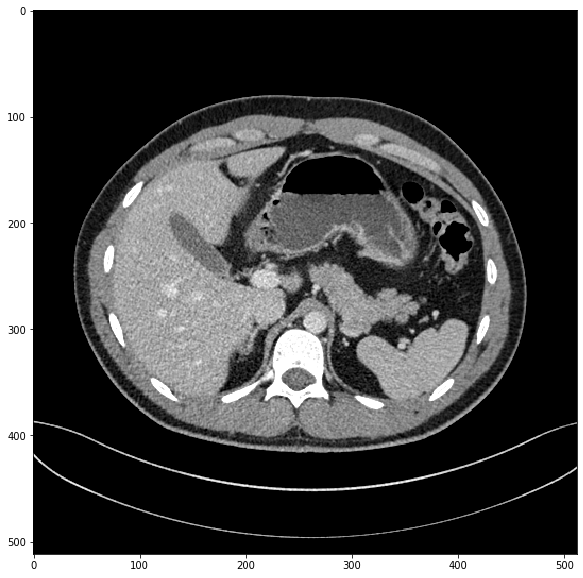

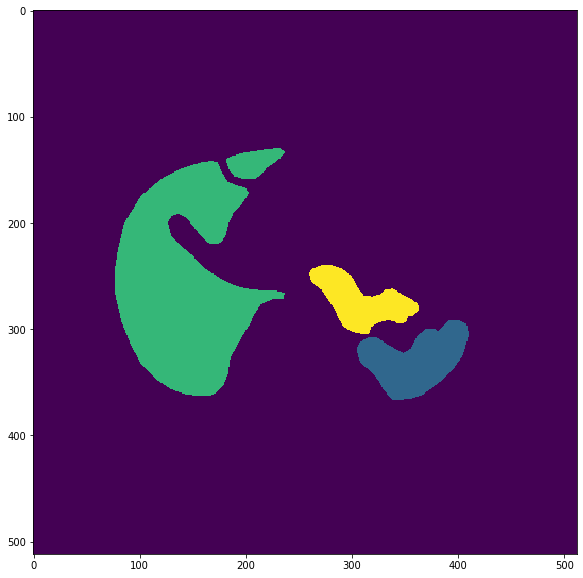

In [25]:
sliceNumber = 203

segUno = data_maskUno[:,:,sliceNumber]
segDos = data_maskDos[:,:,sliceNumber]
imageExtract = data_img[:,:,sliceNumber]
segMulti = data_maskMultilabel[:,:, sliceNumber]


imageExtract = cv2.rotate(imageExtract, cv2.cv2.ROTATE_90_CLOCKWISE)
imageExtract = cv2.flip(imageExtract,1)

## rotación de mascaras
## Mask 1
segUno = cv2.rotate(segUno, cv2.cv2.ROTATE_90_CLOCKWISE)
segUno = cv2.flip(segUno,1)

## Mask 2
segDos = cv2.rotate(segDos, cv2.cv2.ROTATE_90_CLOCKWISE)
segDos = cv2.flip(segDos,1)

## mask multilabel

## Mask 2
segMulti = cv2.rotate(segMulti, cv2.cv2.ROTATE_90_CLOCKWISE)
segMulti = cv2.flip(segMulti,1)


segDosBin = np.where(segDos>0,1,0)



plt.figure(figsize=(10,10))
plt.imshow(show_slice_window(imageExtract, 50,400), cmap='gray')
plt.savefig('imagenCTMulti.png', dpi=600)

plt.show()

plt.figure(figsize=(10,10))
#plt.title("Segmentación operador 1")
plt.imshow(segMulti, cmap='viridis')
plt.savefig('segmentacionmultiple.png', dpi=300)
plt.show()



(30, 35)


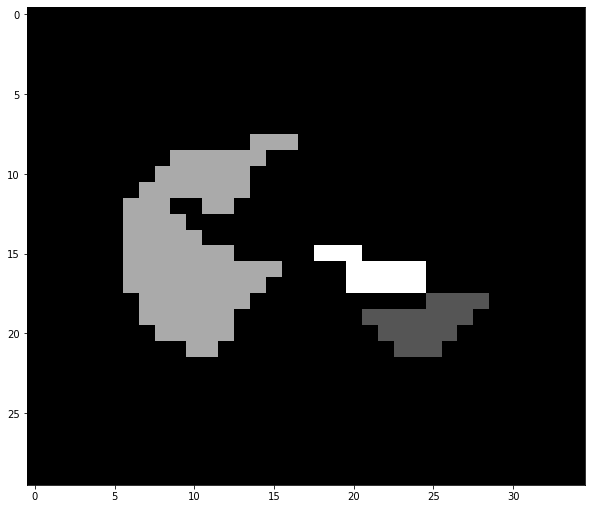

In [26]:
## redimensionado
dim = 35,30

imgResMulti = cv2.resize(segMulti, dim,
               interpolation = cv2.INTER_NEAREST)

print(imgResMulti.shape)
 
plt.figure(figsize=(10,10))
plt.imshow(imgResMulti, cmap='gray')
plt.savefig('masklowResMulti.png', dpi=300)

In [28]:

#df = pd.DataFrame(imgResMulti)

#df_styled = df.style.background_gradient()
#dfi.export (df_styled, 'df_ct.png')
#dfi.export (df, 'df_ct_multi2.png')

#dfi.export(df_styled, 'mascaracolorversionMulti.png', max_cols=-1)
#dfi.export (df, 'mascara.png', max_cols=-1)

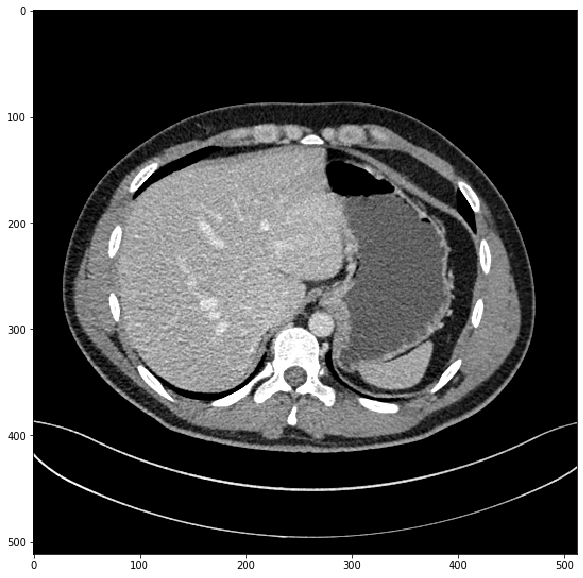

Área de Mask 1: 30323


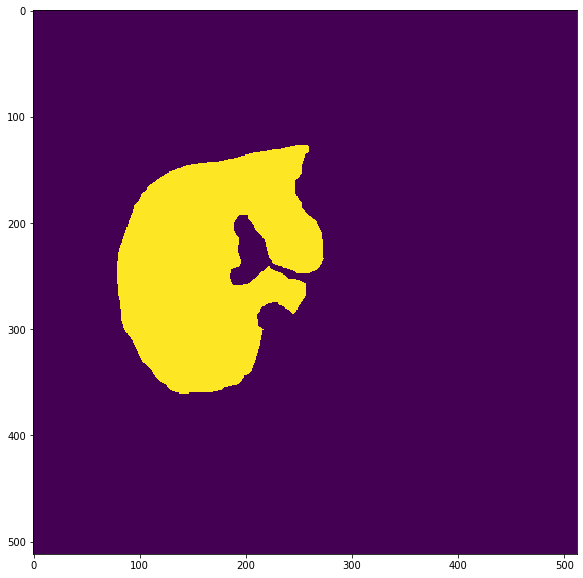

Área de Mask 2: 26585
Área de Mask 2: 160.643399810791 cm2


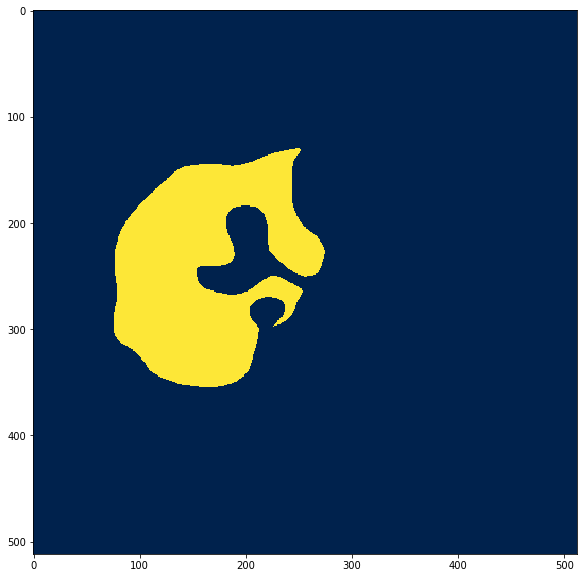

Diferencia entre las dos máscaras: 3738.0
Diferencia % entre las dos máscaras: 0.1232727632490189


In [29]:
sliceNumber = 214

segUno = data_maskUno[:,:,sliceNumber]
segDos = data_maskDos[:,:,sliceNumber]
imageExtract = data_img[:,:,sliceNumber]


imageExtract = cv2.rotate(imageExtract, cv2.cv2.ROTATE_90_CLOCKWISE)
imageExtract = cv2.flip(imageExtract,1)

## rotación de mascaras
## Mask 1
segUno = cv2.rotate(segUno, cv2.cv2.ROTATE_90_CLOCKWISE)
segUno = cv2.flip(segUno,1)

## Mask 2
segDos = cv2.rotate(segDos, cv2.cv2.ROTATE_90_CLOCKWISE)
segDos = cv2.flip(segDos,1)

segDosBin = np.where(segDos>0,1,0)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.savefig('imagenCT.png', dpi=600)

plt.show()

print("Área de Mask 1:", segUno.sum())
plt.figure(figsize=(10,10))
#plt.title("Segmentación operador 1")
plt.imshow(segUno, cmap='viridis')
plt.savefig('maskoperador1.png', dpi=600)
plt.show()

print("Área de Mask 2:", segDosBin.sum())
print("Área de Mask 2:", segDosBin.sum() * (header_img['space directions'][0][0]/10 * header_img['space directions'][1][1]/10), "cm2")
plt.figure(figsize=(10,10))
#plt.title("Segmentación operador 2")
plt.imshow(segDosBin, cmap='cividis')
plt.savefig('maskoperador2.png', dpi=600)

plt.show()

print("Diferencia entre las dos máscaras:",segUno.sum() - segDosBin.sum())
print("Diferencia % entre las dos máscaras:",(segUno.sum() - segDosBin.sum())/segUno.sum() )

In [30]:
header_img['space directions'][1][1]/10

0.077734375

In [31]:
print(segUno.shape)
print(segUno.sum())
print(segUno.max())

print(segDos.shape)
print(segDos.sum())
print(segDos.max())

(512, 512)
30323
1
(512, 512)
79755
3


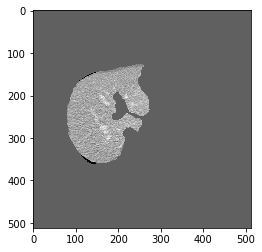

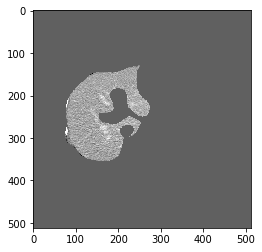

In [32]:
## extracciones hepaticas

liverUno = np.where(segUno == 1, image, 0)
liverDos = np.where(segDos > 0, image, 0)

kernel = np.ones((3, 3), np.uint16)
  
# Using cv2.erode() method 
liverDosErode = cv2.erode(liverDos, kernel) 

plt.figure()
plt.imshow(liverUno, cmap='gray')
plt.show()

plt.figure()
plt.imshow(liverDos, cmap='gray')
plt.show()

#plt.figure()
#plt.imshow(liverDosErode, cmap='gray')
#plt.show()



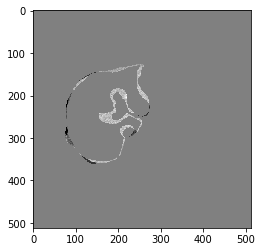

In [33]:
## Diferencia mask

maskDif = liverUno - liverDos

plt.figure()
plt.imshow(maskDif, cmap='gray')

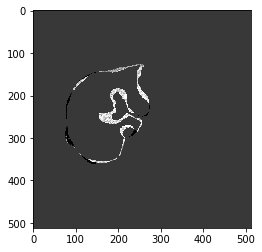

In [34]:
liverDif = show_slice_window(maskDif, 50,180)

plt.figure()
plt.imshow(liverDif, cmap='gray')

In [35]:
segDosP = np.where(segDos > 0,1,0)

In [36]:
from sklearn.metrics import classification_report

print(classification_report(segUno.flatten(), segDosP.flatten()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    231821
           1       0.97      0.85      0.91     30323

    accuracy                           0.98    262144
   macro avg       0.98      0.92      0.95    262144
weighted avg       0.98      0.98      0.98    262144



In [37]:
## Diferencias de Dice

from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

print('Dice Score:', f1_score(segUno, segDosP, average='micro'))
print('Jaccard Score:', jaccard_score(segUno, segDosP,average='micro'))

Dice Score: 0.9065157798552049
Jaccard Score: 0.8290158770971267


In [38]:
import seg_metrics.seg_metrics as sg


labels = [0, 1]
#gdth_img = np.array([0,0,1,1,2])
#pred_img = np.array([0,0,1,2,2])
csv_file = 'metricsLiver.csv'

metrics = sg.write_metrics(labels=labels[1:],  # exclude background if needed
                  gdth_img=segUno,
                  pred_img=segDosP,
                  csv_file=csv_file,
                  metrics=['dice', 'hd', 'msd','vs'])
print(metrics)

1it [00:00, 11.51it/s]


start to get metrics for label:  1
Metrics were saved at :  metricsLiver.csv
[{'label': [1], 'dice': [0.9065157639257089], 'vs': [0.13136993041400155], 'hd': [31.400636672973633], 'msd': [5.150063962616401]}]


In [39]:
## Evaluación volumétrica

imagenes = np.array(imagenes)
mascaras = np.array(mascaras)

print(imagenes.shape)
print(mascaras.shape)


(1, 512, 512)
(1, 512, 512)


In [123]:
def rotateMask(mask):
    maskRot = cv2.rotate(mask, cv2.cv2.ROTATE_90_CLOCKWISE)
    maskRot = cv2.flip(maskRot,1)
    return(maskRot)
    
    

In [128]:
volumenRotado = np.zeros(mascaras.shape, dtype='uint8')

for i in range(mascaras.shape[0]):
    mask = mascaras[i,:,:]
    maskRot = rotateMask(mask)
    volumenRotado[i,:,:] = maskRot

In [129]:
volumenRotado.shape

(77, 512, 512)

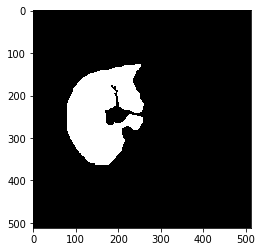

In [132]:

plt.figure()
plt.imshow(volumenRotado[40,:,:], cmap='gray')

In [144]:
## Resize imagenes para mayor comodidad en procesamiento

imgResize = []
maskResize = []
dim = 64,64

for i in range(imagenes.shape[0]):
    img = imagenes[i,:,:]
    imgRes = cv2.resize(img,dim, interpolation = cv2.INTER_CUBIC )
    mask = mascaras[i,:,:]
    maskRes = cv2.resize(mask,dim, interpolation = cv2.INTER_CUBIC )
    imgResize.append(imgRes)
    maskResize.append(maskRes)
    
imgResize = np.array(imgResize)
maskResize = np.array(maskResize)

In [145]:
print(imgResize.shape)
print(maskResize.shape)

(77, 64, 64)
(77, 64, 64)


In [150]:
volumenRotado2 = np.zeros(maskResize.shape, dtype='uint8')

for i in range(maskResize.shape[0]):
    mask = maskResize[i,:,:]
    maskRot = rotateMask(mask)
    volumenRotado2[i,:,:] = maskRot

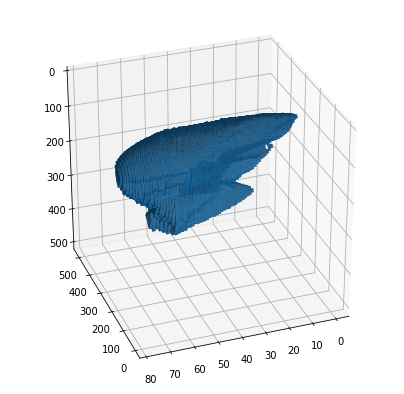

tiempo iteración: 572.3925940990448


In [191]:
from mpl_toolkits import mplot3d
import time

start = time.time()

ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.voxels(volumenRotado, edgecolor=None, cmap='plasma')

angulo_elevacion = 210
angulo_rotacion = 110

ax.view_init(angulo_elevacion, angulo_rotacion)
plt.savefig('LiverVol3D.png', dpi=600)
plt.show()


print("tiempo iteración:", time.time()-start)

In [192]:
## segundo modelo 3d

from tqdm import tqdm
import os
from random import randint


import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import nrrd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim

import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif

import warnings
warnings.simplefilter("ignore")

/opt/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [207]:
class ImageToGIF:
    """Create GIF without saving image files."""
    def __init__(self,
                 size=(600, 400), 
                 xy_text=(80, 10),
                 dpi=300, 
                 cmap='CMRmap'):

        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / dpi, size[1] / dpi)
        self.xy_text = xy_text
        self.cmap = cmap
        
        self.ax = self.fig.add_axes([0, 0, 1, 1])
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.images = []
 
    def add(self, *args, label, with_mask=True):
        
        image = args[0]
        mask = args[-1]
        plt.set_cmap(self.cmap)
        plt_img = self.ax.imshow(image, animated=True)
        if with_mask:
            plt_mask = self.ax.imshow(np.ma.masked_where(mask == False, mask),
                                      alpha=0.7, animated=True)

        plt_text = self.ax.text(*self.xy_text, label, color='red')
        to_plot = [plt_img, plt_mask, plt_text] if with_mask else [plt_img, plt_text]
        self.images.append(to_plot)
        plt.close()
 
    def save(self, filename, fps):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=fps)
        
        
class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """
    def __init__(self, 
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
    
    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z
    
    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        return arr / arr.max()
    
    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean
    
    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, mode='constant')
        return resized_data
    
    def plot_cube(self,
                  cube,
                  title: str = '', 
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
        """
        Plot 3d data.
        Parameters:
            cube: 3d data
            title: title for figure.
            init_angle: angle for image plot (from 0-360).
            make_gif: if True create gif from every 5th frames from 3d image plot.
            path_to_save: path to save GIF file.
            """
        cube = self._normalize(cube)

        facecolors = cm.gist_stern(cube)
        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(200, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
            

            plt.savefig('3DvolLiverFull.png', dpi=300)
            plt.show()

(55, 55, 55)


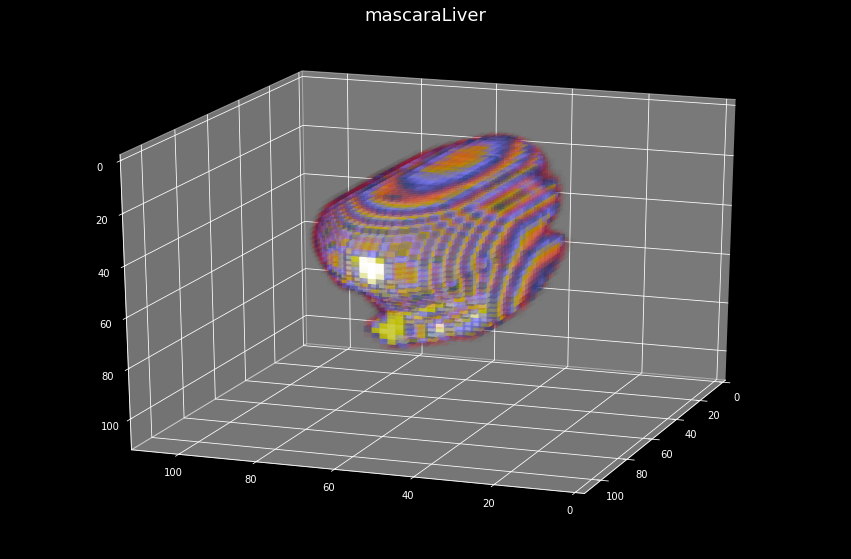

FileNotFoundError: No such file or directory: 'mascaraLiver_3d.gif'

FileNotFoundError: No such file or directory: 'mascaraLiver_3d.gif'

<IPython.core.display.Image object>

In [208]:
title = "mascaraLiver"
filename = title+"_3d.gif"

data_to_3dgif = Image3dToGIF3d()#img_dim = (120, 120, 78)
transformed_data = data_to_3dgif.get_transformed_data(volumenRotado)
data_to_3dgif.plot_cube(
    transformed_data,#[:77, :105, :55]
    title=title,
    make_gif=False,
    init_angle = -200,
    path_to_save=filename
)
show_gif(filename, format='png')